# Digit Recognizer 

by Onkar Suhas Samant

#  Executive Summary


**Goal:** <br>

Recognize hand written digits' images (32x32 pixels in grey scale) and predict the labels which are from 0 to 9. 
It's also an ongoing competition. <br> 
Kaggle link: https://www.kaggle.com/c/digit-recognizer

**Dataset:** <br>

The dataset is obtained from the link above <br>
- Training dataset: 42,000 images, labeled 
- Test dataset: 28,000, unlabeled

Since we do not have labels for the test set we create a test set from the training set (20% of training set, technically validation set) and tabulate the results

<br>
    
**Key takeaways:** <br>

- Following are results on the test dataset 

| Model | Test Set Accuracy |
| :-: | :-: |
| Logistic Regression | 0.92 |
| Shallow Neural Network | 0.89 | 
| Fully Connected Neural Network  | 0.94 |
| Optimized Fully Connected Neural Network | 0.97 | 
| CNN architecture | 0.99|

- Logistic Regression serves as the baseline for all the models


- Neural Networks with more than 2 hidden layers performs well on this dataset. The optimized Fully Connected Neural Network Architechture has 3 Hidden layers of 128 nodes and Dropout Regularization


- Convolutional Neural Network Architechture performs exceptionally well on the dataset. The Architecture is inspired from LeNet-5 architecture. It has 2 Convolution Layers (filter size - 3x3), 2 Fully Connected layers (128, 64 nodes) and Dropout Regularization <br>




**Kaggle Submission Result:** Accuracy = 0.989 (Top 40 percentile) on unlabeled dataset


#  Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Activation
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers;

Using TensorFlow backend.


In [2]:
digits_train = pd.read_csv("train.csv")
digits_test = pd.read_csv("test.csv")

# Explorarary Data Analysis

##  Structure of Data

In [3]:
digits_train.shape

(42000, 785)

Training dataset:
-  28x28 image in 784 columns and 1 label
- 42000 images

In [4]:
digits_test.shape

(28000, 784)

Test dataset:
- 28x28 image in 784 columns
- 28000 images

In [5]:
X_test = digits_test

In [6]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]

## Check Null values

In [7]:
digits_train.isna().sum().describe()

count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

There are no null values

##  Visualize the images

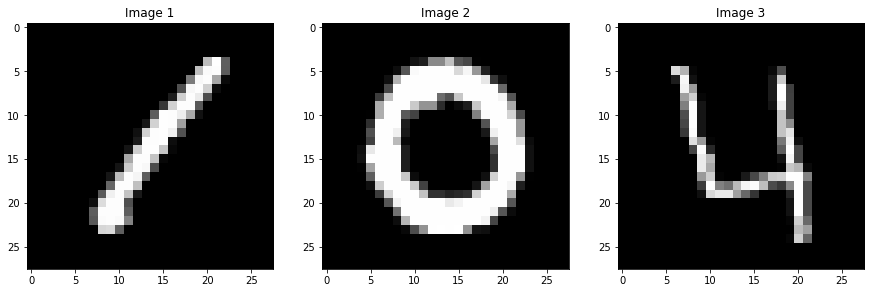

In [8]:
#Let's check how few images look like
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].set_title("Image 1")
ax[0].imshow(np.array(X_train.iloc[0]).reshape(28,28), cmap = "gray")
ax[1].set_title("Image 2")
ax[1].imshow(np.array(X_train.iloc[1]).reshape(28,28), cmap = "gray")
ax[2].set_title("Image 3")
ax[2].imshow(np.array(X_train.iloc[3]).reshape(28,28), cmap = "gray");

##  Distribution of Image labels

In [9]:
y_counts = y_train.value_counts(sort = True, normalize = True)
digits_train.groupby("label").agg({"label":"count"})

,label
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


In [77]:
#Mode of the distribution (Most common value)
digits_train["label"].mode()

0    1
dtype: int64

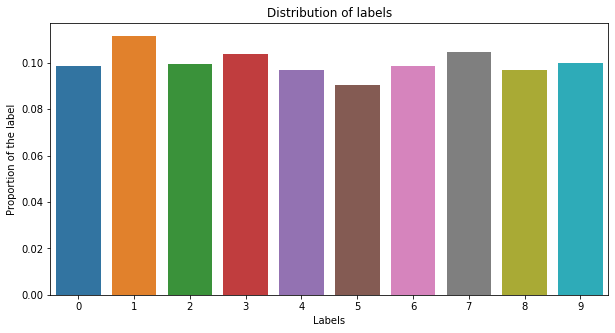

In [10]:
plt.figure(figsize = (10,5))
ax = sns.barplot(x=y_counts.index, y = y_counts.values)
ax.set_title("Distribution of labels")
ax.set_ylabel("Proportion of the label")
ax.set_xlabel("Labels");

We observe the labels are fairly evenly distributed

# Data Engineering / Wrangling

##  Normalizing
Neural networks converge faster for normalized data. The data has max 255 represeting the brightness of the image

In [11]:
X_train = X_train / 255
X_test = X_test / 255

##  Converting labels to categorical outputs

In [12]:
y_train = to_categorical(y_train, num_classes = 10)

##  Splitting the training data
- training set
- test set

We do not have labels for the test set provided on Kaggle. Hence, we test on them later with the best model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

## Reshaping data for use in CNN
- Length x width = 28 x 28
- Channel = 1

In [14]:
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

# Modeling

In [15]:
Summary_table = pd.DataFrame(columns = ["model", "Test accuracy"])

## Logistic Regression
Baseline model for comparison 

In [16]:
lr = LogisticRegression(solver = "lbfgs", max_iter = 1000)

In [17]:
lr.fit(X_train, np.argmax(y_train, axis = 1));

In [18]:
test_accuracy = lr.score(X_test, np.argmax(y_test, axis = 1))

In [19]:
Summary_table  = Summary_table.append({"model": "Logistic Regression", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [20]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.921


## Shallow fully connected Neural Network
- Hidden layer1: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations

In [21]:
model_s = Sequential()
model_s.add(Dense(5, input_shape = (784,), activation = "relu"))
#Output layer
model_s.add(Dense(10, activation = "softmax"))
model_s.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [22]:
model_s.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


There are:
- Layer1: Weights =  784*5, Bias(each node's) = 5. Total = 3925
- Layer2 (output): Weights = 5*10 = 50, Bias (each node's) = 10. Total 60

Toatal parameters = 3985

In [23]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10)

In [24]:
history = model_s.fit(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [early_stopping]);

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 5s 180us/step - loss: 1.1677 - accuracy: 0.6351 - val_loss: 0.7051 - val_accuracy: 0.7899
Epoch 2/100
26880/26880 [==============================] - 4s 157us/step - loss: 0.6243 - accuracy: 0.8126 - val_loss: 0.5501 - val_accuracy: 0.8324
Epoch 3/100
26880/26880 [==============================] - 5s 171us/step - loss: 0.5251 - accuracy: 0.8433 - val_loss: 0.4933 - val_accuracy: 0.8503
Epoch 4/100
26880/26880 [==============================] - 5s 174us/step - loss: 0.4735 - accuracy: 0.8586 - val_loss: 0.4495 - val_accuracy: 0.8665
Epoch 5/100
26880/26880 [==============================] - 5s 168us/step - loss: 0.4390 - accuracy: 0.8688 - val_loss: 0.4245 - val_accuracy: 0.8737
Epoch 6/100
26880/26880 [==============================] - 5s 173us/step - loss: 0.4143 - accuracy: 0.8786 - val_loss: 0.4163 - val_accuracy: 0.8762
Epoch 7/100
26880/26880 [==============================] 

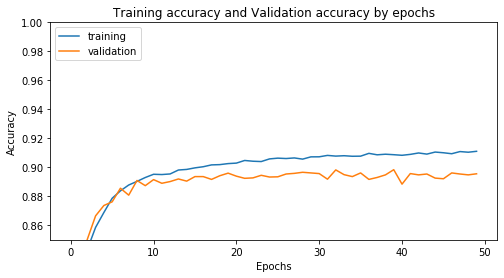

In [25]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.85,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [26]:
test_accuracy = model_s.evaluate(X_test, y_test)[1]

8400/8400 [==============================] - 0s 21us/step


In [27]:
Summary_table  = Summary_table.append({"model": "Shallow NN", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [28]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.921
1,Shallow NN,0.894


Observation:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.09
- Test accuracy: 0.11

Therefore, we can focus on trying to decrease the gap between bayes error and training error with **more complex model**


## Fully Connected Neural Network (2 Hidden Layers, 5 nodes) 
- Hidden layer1: 5 nodes, activation function: relu
- Hidden layer2: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [29]:
model_fc = Sequential()
model_fc.add(Dense(5, input_shape = (784,), activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(5, activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(10, activation = "softmax"))

In [30]:
model_fc.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics =["accuracy"])

In [31]:
model_fc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 3925      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
batch_normalization_2 (Batch (None, 5)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                60        
Total params: 4,055
Trainable params: 4,035
Non-trainable params: 20
_________________________________________________________________


In [32]:
history = model_fc.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping], epochs = 100);

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 4s 141us/step - loss: 1.2527 - accuracy: 0.5961 - val_loss: 0.8406 - val_accuracy: 0.7513
Epoch 2/100
26880/26880 [==============================] - 4s 131us/step - loss: 0.7430 - accuracy: 0.7760 - val_loss: 0.6628 - val_accuracy: 0.7991
Epoch 3/100
26880/26880 [==============================] - 3s 124us/step - loss: 0.6357 - accuracy: 0.8100 - val_loss: 0.5773 - val_accuracy: 0.8304
Epoch 4/100
26880/26880 [==============================] - 4s 144us/step - loss: 0.5788 - accuracy: 0.8297 - val_loss: 0.5263 - val_accuracy: 0.8461
Epoch 5/100
26880/26880 [==============================] - 5s 178us/step - loss: 0.5534 - accuracy: 0.8360 - val_loss: 0.5128 - val_accuracy: 0.8525
Epoch 6/100
26880/26880 [==============================] - 3s 127us/step - loss: 0.5406 - accuracy: 0.8392 - val_loss: 0.5237 - val_accuracy: 0.8427
Epoch 7/100
26880/26880 [==============================] 

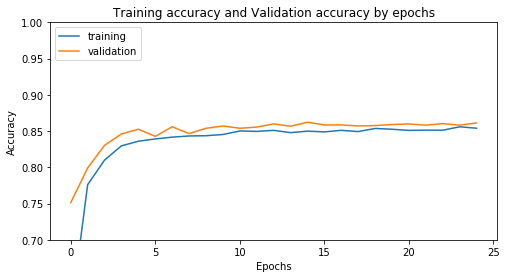

In [33]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.7,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [34]:
test_accuracy = model_fc.evaluate(X_test, y_test)[1]

8400/8400 [==============================] - 0s 36us/step


In [35]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,5 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

Observations: <br>
Increasing  a layer has actually decrased the accuracy rather than increasing. The network needs more width (numer of nodes)

## Fully Connected Neural Network (2 Hidden Layers, 16 nodes)
- Hidden layer1: 16 nodes, activation function: relu
- Hidden layer2: 16 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [36]:
model_fc16 = Sequential()
model_fc16.add(Dense(16, input_shape = (784,), activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(16, activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(10, activation = "softmax"))

In [37]:
model_fc16.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [38]:
model_fc16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                12560     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                170       
Total params: 13,130
Trainable params: 13,066
Non-trainable params: 64
_________________________________________________________________


In [39]:
history = model_fc16.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 5s 168us/step - loss: 0.7113 - accuracy: 0.7992 - val_loss: 0.3492 - val_accuracy: 0.9003
Epoch 2/100
26880/26880 [==============================] - 6s 223us/step - loss: 0.3513 - accuracy: 0.8966 - val_loss: 0.2889 - val_accuracy: 0.9176
Epoch 3/100
26880/26880 [==============================] - 4s 135us/step - loss: 0.3098 - accuracy: 0.9074 - val_loss: 0.2716 - val_accuracy: 0.9235
Epoch 4/100
26880/26880 [==============================] - 4s 141us/step - loss: 0.2873 - accuracy: 0.9131 - val_loss: 0.2549 - val_accuracy: 0.9290
Epoch 5/100
26880/26880 [==============================] - 5s 178us/step - loss: 0.2621 - accuracy: 0.9221 - val_loss: 0.2553 - val_accuracy: 0.9244
Epoch 6/100
26880/26880 [==============================] - 6s 222us/step - loss: 0.2495 - accuracy: 0.9241 - val_loss: 0.2428 - val_accuracy: 0.9301
Epoch 7/100
26880/26880 [==============================] 

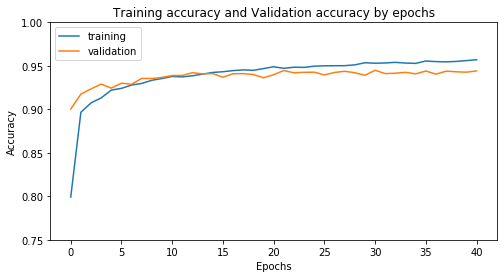

In [40]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.75,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [41]:
test_accuracy = model_fc16.evaluate(X_test, y_test)[1]

8400/8400 [==============================] - 0s 18us/step


In [42]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,16 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [43]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.921
1,Shallow NN,0.894
2,"NN 2 HL,5 nodes",0.863
3,"NN 2 HL,16 nodes",0.940


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.04
- Test accuracy: 0.06

We have successfully reduced the bias but there still is 0.04 reducable bias which can be tackled with **more complex model**

## Optimizing Fully Connected Neural Network
Based on our observation so far, we can optimize the neural network with hyperparamters tuning:
- Optimizer: Stochastic Gradient Descent and Adam
- Nodes: 16, 32, 64, 128
- Hidden Layers: 2,3,4
- Activation function: relu, tanh

In [44]:
def create_model(optimizer ="adam", hl = 2, nodes = 16, activation = "relu"):
    model = Sequential()
    model.add(Dense(nodes, input_shape = (784,), activation = activation))
    l=1
    while(l < hl):
        model.add(Dense(nodes,activation = activation))
        model.add(BatchNormalization())
        l+=1
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy",metrics = ["accuracy"])
    return model

In [45]:
NN_parameters = {"optimizer":["sgd", "adam"], "hl":[2,3,4], "nodes":[16,32,64,128], "activation":["relu","tanh"]}

In [46]:
model = KerasClassifier(build_fn = create_model, epochs = 10)

In [47]:
RS_CV = RandomizedSearchCV(model, n_iter = 10, param_distributions = NN_parameters, cv = 3)

In [48]:
RS_CV.fit(X_train, y_train)

Epoch 1/10
22400/22400 [==============================] - ETA: 0s - loss: 0.7776 - accuracy: 0.77 - 1s 61us/step - loss: 0.7679 - accuracy: 0.7828
Epoch 2/10
22400/22400 [==============================] - 1s 51us/step - loss: 0.3333 - accuracy: 0.9043
Epoch 3/10
22400/22400 [==============================] - 1s 50us/step - loss: 0.2643 - accuracy: 0.9218
Epoch 4/10
22400/22400 [==============================] - 1s 50us/step - loss: 0.2254 - accuracy: 0.9329
Epoch 5/10
22400/22400 [==============================] - 1s 50us/step - loss: 0.2009 - accuracy: 0.9408
Epoch 6/10
22400/22400 [==============================] - 1s 50us/step - loss: 0.1861 - accuracy: 0.9432
Epoch 7/10
22400/22400 [==============================] - 1s 50us/step - loss: 0.1668 - accuracy: 0.9495
Epoch 8/10
22400/22400 [==============================] - 1s 48us/step - loss: 0.1632 - accuracy: 0.9485
Epoch 9/10
22400/22400 [==============================] - 1s 49us/step - loss: 0.1480 - accuracy: 0.9552
Epoch 10/10
1

22400/22400 [==============================] - 1s 67us/step - loss: 0.3122 - accuracy: 0.9083
Epoch 3/10
22400/22400 [==============================] - 1s 65us/step - loss: 0.2550 - accuracy: 0.9248
Epoch 4/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.2194 - accuracy: 0.9355
Epoch 5/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.1898 - accuracy: 0.9455
Epoch 6/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.1691 - accuracy: 0.9515
Epoch 7/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.1491 - accuracy: 0.9574
Epoch 8/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.1340 - accuracy: 0.9621
Epoch 9/10
22400/22400 [==============================] - 1s 65us/step - loss: 0.1212 - accuracy: 0.9647
Epoch 10/10
11200/11200 [==============================] - 0s 26us/step
Epoch 1/10
22400/22400 [==============================] - 2s 74us/step - loss: 0.4948 - accuracy: 0

22400/22400 [==============================] - 2s 76us/step - loss: 0.1579 - accuracy: 0.9519
Epoch 4/10
22400/22400 [==============================] - 2s 69us/step - loss: 0.1289 - accuracy: 0.9599
Epoch 5/10
22400/22400 [==============================] - 2s 69us/step - loss: 0.1005 - accuracy: 0.9676 0s -
Epoch 6/10
22400/22400 [==============================] - 2s 69us/step - loss: 0.0964 - accuracy: 0.9680
Epoch 7/10
22400/22400 [==============================] - 2s 71us/step - loss: 0.0813 - accuracy: 0.9736 0s - los
Epoch 8/10
22400/22400 [==============================] - 2s 71us/step - loss: 0.0742 - accuracy: 0.9757
Epoch 9/10
22400/22400 [==============================] - 2s 71us/step - loss: 0.0694 - accuracy: 0.9766
Epoch 10/10
11200/11200 [==============================] - 0s 27us/step
Epoch 1/10
22400/22400 [==============================] - 1s 60us/step - loss: 0.5427 - accuracy: 0.8391
Epoch 2/10
22400/22400 [==============================] - 1s 53us/step - loss: 0.3208

22400/22400 [==============================] - 2s 104us/step - loss: 0.1832 - accuracy: 0.9435
Epoch 6/10
22400/22400 [==============================] - 2s 108us/step - loss: 0.1663 - accuracy: 0.9483
Epoch 7/10
22400/22400 [==============================] - 4s 175us/step - loss: 0.1562 - accuracy: 0.9533
Epoch 8/10
22400/22400 [==============================] - 2s 74us/step - loss: 0.1452 - accuracy: 0.9558
Epoch 9/10
22400/22400 [==============================] - 1s 66us/step - loss: 0.1355 - accuracy: 0.9573
Epoch 10/10
11200/11200 [==============================] - 0s 37us/step
Epoch 1/10
22400/22400 [==============================] - 4s 171us/step - loss: 0.5743 - accuracy: 0.8396
Epoch 2/10
22400/22400 [==============================] - 4s 157us/step - loss: 0.2830 - accuracy: 0.9173
Epoch 3/10
22400/22400 [==============================] - 5s 207us/step - loss: 0.2313 - accuracy: 0.9322
Epoch 4/10
22400/22400 [==============================] - 4s 190us/step - loss: 0.2063 - accu

22400/22400 [==============================] - 3s 125us/step - loss: 0.2432 - accuracy: 0.9297
Epoch 9/10
22400/22400 [==============================] - 5s 204us/step - loss: 0.2364 - accuracy: 0.9312
Epoch 10/10
11200/11200 [==============================] - 1s 76us/step
Epoch 1/10
22400/22400 [==============================] - 4s 178us/step - loss: 0.9104 - accuracy: 0.7479
Epoch 2/10
22400/22400 [==============================] - 4s 158us/step - loss: 0.4405 - accuracy: 0.8875
Epoch 3/10
22400/22400 [==============================] - 2s 92us/step - loss: 0.3499 - accuracy: 0.9026
Epoch 4/10
22400/22400 [==============================] - 2s 98us/step - loss: 0.2983 - accuracy: 0.9166
Epoch 5/10
22400/22400 [==============================] - 3s 141us/step - loss: 0.2685 - accuracy: 0.9242
Epoch 6/10
22400/22400 [==============================] - 3s 125us/step - loss: 0.2422 - accuracy: 0.9315
Epoch 7/10
22400/22400 [==============================] - 3s 150us/step - loss: 0.2263 - accu

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024F81BC1708>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'hl': [2, 3, 4],
                                        'nodes': [16, 32, 64, 128],
                                        'optimizer': ['sgd', 'adam']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [49]:
RS_CV.best_params_

{'optimizer': 'sgd', 'nodes': 128, 'hl': 3, 'activation': 'relu'}

Best parameters:
- Optimizer: Stochastic Gradient Descent
- 3 hidden layers
- Activation relu

In [52]:
model_fc_o = create_model(optimizer= "sgd", nodes = 128, hl = 3, activation = "relu")

In [53]:
history = model_fc_o.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 5s 181us/step - loss: 0.4457 - accuracy: 0.8662 - val_loss: 0.2230 - val_accuracy: 0.9338
Epoch 2/100
26880/26880 [==============================] - 9s 321us/step - loss: 0.2128 - accuracy: 0.9376 - val_loss: 0.1664 - val_accuracy: 0.9501
Epoch 3/100
26880/26880 [==============================] - 5s 173us/step - loss: 0.1594 - accuracy: 0.9527 - val_loss: 0.1498 - val_accuracy: 0.9536
Epoch 4/100
26880/26880 [==============================] - 4s 164us/step - loss: 0.1274 - accuracy: 0.9628 - val_loss: 0.1345 - val_accuracy: 0.9580
Epoch 5/100
26880/26880 [==============================] - 6s 205us/step - loss: 0.1072 - accuracy: 0.9683 - val_loss: 0.1214 - val_accuracy: 0.9668
Epoch 6/100
26880/26880 [==============================] - 6s 233us/step - loss: 0.0885 - accuracy: 0.9740 - val_loss: 0.1171 - val_accuracy: 0.9659
Epoch 7/100
26880/26880 [==============================] 

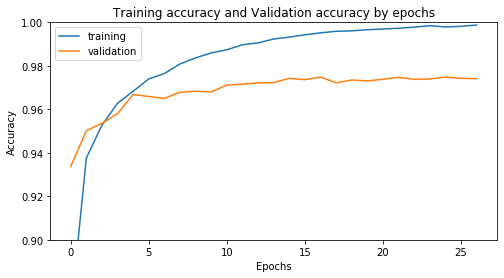

In [54]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [55]:
test_accuracy = model_fc_o.evaluate(X_test, y_test)[1]

8400/8400 [==============================] - 0s 40us/step


In [56]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes)", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [57]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.921
1,Shallow NN,0.894
2,"NN 2 HL,5 nodes",0.863
3,"NN 2 HL,16 nodes",0.940
4,"Opimized NN (3 HL, 128 nodes)",0.970


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.002
- Test error: 0.030

We have successfully reduced the bias but there is varaince now due to **overfitting**.Variance can be decreased by:
- Drop out regularization
- l2 Regularization 

## Dropout Regularization 

In [58]:
model_fc_r = Sequential()
model_fc_r.add(Dense(128, input_shape = (784,), activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(10, activation = "softmax"))

In [59]:
model_fc_r.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [60]:
history = model_fc_r.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 6s 233us/step - loss: 0.6967 - accuracy: 0.7805 - val_loss: 0.2530 - val_accuracy: 0.9265
Epoch 2/100
26880/26880 [==============================] - 5s 201us/step - loss: 0.3911 - accuracy: 0.8819 - val_loss: 0.2004 - val_accuracy: 0.9421
Epoch 3/100
26880/26880 [==============================] - 6s 230us/step - loss: 0.3175 - accuracy: 0.9028 - val_loss: 0.1710 - val_accuracy: 0.9488
Epoch 4/100
26880/26880 [==============================] - 6s 222us/step - loss: 0.2776 - accuracy: 0.9148 - val_loss: 0.1482 - val_accuracy: 0.9571
Epoch 5/100
26880/26880 [==============================] - 5s 198us/step - loss: 0.2490 - accuracy: 0.9249 - val_loss: 0.1379 - val_accuracy: 0.9603
Epoch 6/100
26880/26880 [==============================] - 5s 204us/step - loss: 0.2269 - accuracy: 0.9318 - val_loss: 0.1302 - val_accuracy: 0.9624
Epoch 7/100
26880/26880 [==============================] 

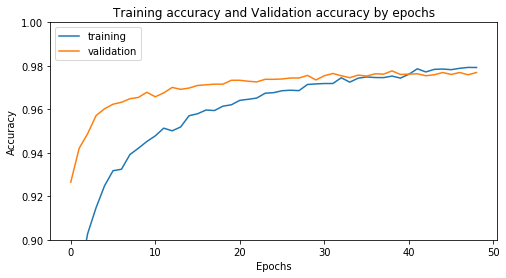

In [61]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [62]:
test_accuracy = model_fc_r.evaluate(X_test, y_test)[1]

8400/8400 [==============================] - 0s 28us/step


In [63]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes) with Dropout", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [64]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.921
1,Shallow NN,0.894
2,"NN 2 HL,5 nodes",0.863
3,"NN 2 HL,16 nodes",0.940
4,"Opimized NN (3 HL, 128 nodes)",0.970
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.976


Observation: <br>

 We reduced the variance using regularization and the model generalizes beeter 

## Convolutional Neural Network 
CNNs are great for image detection for following reasons: 
- **Lesser number of parameters to train**: CNNs filters involve paramter sharing across the image
- **Sparsity of connections**: Each output is connected to a only a few inputs in CNNs, unlike fully connected layer where every input is connected to the output
- **Roboust to translation in variance**: CNNs are robust to translation in variance of the image. This generally happens when the image is roatated, shifted, cropped however the image label is same hence this proprety is desirable in image recognition 

Trying a model similar to the LeNet-5 architechture
- Layer1: CONV layer filter size 3x3, stride 1, Maxpooling layer 2x2, Batch Normalizaton
- Layer2: CONV layer filter size 3x3, stride 1, Maxpooling layer 2x2, Batch Normalizaton
- Layer3: Fully connected layer 128 nodes with Dropout
- Layer4: Fully connected layer 64 nodes with Dropout

In [65]:
model_cnn1 = Sequential()
#Layer1
model_cnn1.add(Conv2D(filters = 8, kernel_size = (3,3), input_shape = (28,28,1), name= "conv0"))
model_cnn1.add(BatchNormalization(name = "bn0"))
model_cnn1.add(Activation("relu", name = "ac0"))
model_cnn1.add(MaxPooling2D(pool_size = (2,2), name = "mp0"))
#Layer2
model_cnn1.add(Conv2D(filters = 16, kernel_size = (3,3), name = "conv1"))
model_cnn1.add(BatchNormalization(name = "bn1"))
model_cnn1.add(Activation("relu", name="ac1"))
model_cnn1.add(MaxPooling2D(pool_size = (2,2), name = "mp1"))
#Flatten Outputs
model_cnn1.add(Flatten())
#Layer3
model_cnn1.add(Dense(128, name = "fc0"))
model_cnn1.add(BatchNormalization(name = "bn2"))
model_cnn1.add(Activation("relu", name = "ac2"))
model_cnn1.add(Dropout(0.2))
#Layer4
model_cnn1.add(Dense(64, name = "fc1"))
model_cnn1.add(BatchNormalization(name = "bn3"))
model_cnn1.add(Activation("relu", name = "ac3"))
model_cnn1.add(Dropout(0.2))
#Output
model_cnn1.add(Dense(10, name = "output", activation = "softmax"))

In [66]:
model_cnn1.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 26, 26, 8)         80        
_________________________________________________________________
bn0 (BatchNormalization)     (None, 26, 26, 8)         32        
_________________________________________________________________
ac0 (Activation)             (None, 26, 26, 8)         0         
_________________________________________________________________
mp0 (MaxPooling2D)           (None, 13, 13, 8)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 11, 11, 16)        1168      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 11, 11, 16)        64        
_________________________________________________________________
ac1 (Activation)             (None, 11, 11, 16)      

In [67]:
model_cnn1.compile(optimizer = "adam", loss = "categorical_crossentropy",  metrics = ["accuracy"])

In [68]:
history = model_cnn1.fit(X_train_r, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 9s 339us/step - loss: 0.3480 - accuracy: 0.9041 - val_loss: 0.0873 - val_accuracy: 0.9760
Epoch 2/100
26880/26880 [==============================] - 9s 325us/step - loss: 0.1172 - accuracy: 0.9672 - val_loss: 0.0651 - val_accuracy: 0.9801
Epoch 3/100
26880/26880 [==============================] - 9s 317us/step - loss: 0.0869 - accuracy: 0.9747 - val_loss: 0.0528 - val_accuracy: 0.9836
Epoch 4/100
26880/26880 [==============================] - 8s 311us/step - loss: 0.0730 - accuracy: 0.9776 - val_loss: 0.0522 - val_accuracy: 0.9830
Epoch 5/100
26880/26880 [==============================] - 8s 312us/step - loss: 0.0601 - accuracy: 0.9808 - val_loss: 0.0580 - val_accuracy: 0.9823
Epoch 6/100
26880/26880 [==============================] - 8s 313us/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0542 - val_accuracy: 0.9833
Epoch 7/100
26880/26880 [==============================] 

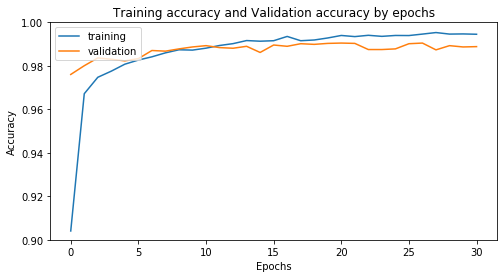

In [69]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [70]:
test_accuracy = model_cnn1.evaluate(X_test_r, y_test)[1]

8400/8400 [==============================] - 1s 98us/step


In [71]:
Summary_table  = Summary_table.append({"model": "CNN architecture", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

In [72]:
Summary_table 

,model,Test accuracy
0,Logistic Regression,0.921
1,Shallow NN,0.894
2,"NN 2 HL,5 nodes",0.863
3,"NN 2 HL,16 nodes",0.940
4,"Opimized NN (3 HL, 128 nodes)",0.970
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.976
6,CNN architecture,0.988


# Submission on Test Data

Training the network on the whole data to submit prediction

In [83]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]
X_train = X_train / 255
X_test = digits_test
X_test = X_test / 255

In [84]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

In [85]:
X_train_r.shape

(42000, 28, 28, 1)

In [86]:
X_test_r.shape

(28000, 28, 28, 1)

In [93]:
model_cnn1.fit(X_train_r, y_train, epochs = 100, validation_split= 0.1, callbacks = [early_stopping])

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 13s 355us/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0049 - val_accuracy: 0.9981
Epoch 2/100
37800/37800 [==============================] - 11s 301us/step - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.0066 - val_accuracy: 0.9983
Epoch 3/100
37800/37800 [==============================] - 11s 301us/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0062 - val_accuracy: 0.9979
Epoch 4/100
37800/37800 [==============================] - 11s 301us/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0086 - val_accuracy: 0.9971
Epoch 5/100
37800/37800 [==============================] - 12s 311us/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.0089 - val_accuracy: 0.9969
Epoch 6/100
37800/37800 [==============================] - 12s 307us/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0118 - val_accuracy: 0.9957
Epoch 7/100
37800/37800 [==========================

In [95]:
predictions = model_cnn1.predict(X_test_r)
predictions = np.argmax(predictions, axis = 1)

In [101]:
submission = pd.DataFrame({"ImageId":np.arange(len(predictions))+1, "Label":predictions}) 

In [102]:
submission.to_csv("submission.csv", index = False)

# Future steps
- Further optimization of hyperparameters of CNN
- Larger architechtures
- Try other regularization techniques like l2
- Implementation of ResNets
- Data Augmentation 
- Ensemble of different architectures and combining results

# Credits 
- Andrew NG (Coursera Deep Learning Specialization)
- Ethan Swan (Lead Data Scientist at 84.51)
- LeNet-5 (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) 
- François Chollet